# Block Position Distribution Comparison
Compare block placement logs from `demo_data_language` and `demo_data_language_uniform` datasets.


In [1]:
from pathlib import Path
import json
import math

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

try:
    import pandas as pd
except ImportError:
    pd = None


In [2]:
# Configuration
DATASETS = {
    "demo_data_language": Path("demo_data_language/remove_red_block_from_plate_so100_smolvla_mujoco/block_pose_log.json"),
    "demo_data_language_uniform": Path("demo_data_language_uniform/remove_red_block_from_plate_so100_smolvla_mujoco/block_pose_log.json"),
}

PLATE_FLAT_RADIUS = 0.10217907939900582  # m, boundary between flat surface and rim
BLOCK_HALF_SIZE = 0.015  # m
BLOCK_CORNER_DISTANCE = BLOCK_HALF_SIZE * math.sqrt(2.0)
CENTER_SAFE_RADIUS = max(PLATE_FLAT_RADIUS - BLOCK_CORNER_DISTANCE, 0.0)

# Helper

def load_block_positions(path: Path) -> np.ndarray:
    if not path.exists():
        raise FileNotFoundError(f"Missing block pose log: {path}")
    with path.open("r", encoding="utf-8") as f:
        entries = json.load(f)
    return np.array([item["block_pose"][:3] for item in entries], dtype=np.float32)

positions = {name: load_block_positions(path) for name, path in DATASETS.items()}

# Estimate plate center from combined samples (robust to small offsets)
all_samples = np.vstack([arr[:, :2] for arr in positions.values()])
PLATE_CENTER = all_samples.mean(axis=0)

print(f"Estimated plate center (x, y): {PLATE_CENTER}")


Estimated plate center (x, y): [ 0.28778476 -0.20482314]


In [3]:
# Summaries
summary_rows = []
for name, pos in positions.items():
    radial = np.linalg.norm(pos[:, :2] - PLATE_CENTER, axis=1)
    summary_rows.append({
        "dataset": name,
        "samples": int(pos.shape[0]),
        "mean_radius": radial.mean(),
        "min_radius": radial.min(),
        "max_radius": radial.max(),
        "std_radius": radial.std(ddof=1) if radial.size > 1 else 0.0,
    })

if pd is not None:
    display(pd.DataFrame(summary_rows).set_index("dataset"))
else:
    for row in summary_rows:
        print(row)


,samples,mean_radius,min_radius,max_radius,std_radius
dataset,,,,,
demo_data_language,20,0.043433,0.018982,0.091162,0.018246
demo_data_language_uniform,20,0.048528,0.022776,0.076101,0.015072


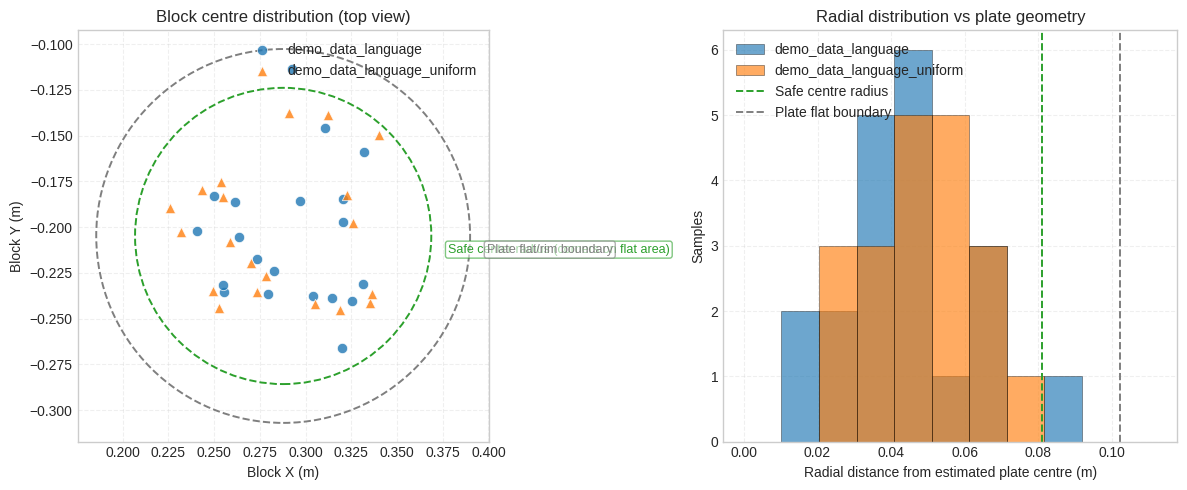

In [4]:
# Visualisation
plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

palette = {
    "demo_data_language": "#1f77b4",
    "demo_data_language_uniform": "#ff7f0e",
}
markers = {
    "demo_data_language": "o",
    "demo_data_language_uniform": "^",
}

ax_xy, ax_hist = axes

for name, pos in positions.items():
    ax_xy.scatter(
        pos[:, 0],
        pos[:, 1],
        label=name,
        alpha=0.8,
        s=55,
        marker=markers[name],
        color=palette[name],
        edgecolors="white",
        linewidths=0.6,
    )

for radius, label, color in [
    (CENTER_SAFE_RADIUS, "Safe center radius (corners on flat area)", "#2ca02c"),
    (PLATE_FLAT_RADIUS, "Plate flat/rim boundary", "#7f7f7f"),
]:
    circle = Circle(tuple(PLATE_CENTER), radius, fill=False, linestyle="--", linewidth=1.4, edgecolor=color)
    ax_xy.add_patch(circle)
    ax_xy.annotate(
        label,
        xy=(PLATE_CENTER[0] + radius, PLATE_CENTER[1]),
        xytext=(12, -12),
        textcoords="offset points",
        color=color,
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color, alpha=0.6),
    )

ax_xy.set_aspect("equal", "box")
ax_xy.set_xlabel("Block X (m)")
ax_xy.set_ylabel("Block Y (m)")
ax_xy.set_title("Block centre distribution (top view)")
ax_xy.grid(alpha=0.3, linestyle="--")
ax_xy.legend()

bins = None
for name, pos in positions.items():
    radial = np.linalg.norm(pos[:, :2] - PLATE_CENTER, axis=1)
    if bins is None:
        bins = np.linspace(0, max(radial.max(), PLATE_FLAT_RADIUS) + 0.01, 12)
    ax_hist.hist(
        radial,
        bins=bins,
        alpha=0.65,
        label=name,
        color=palette[name],
        edgecolor="black",
        linewidth=0.4,
    )

ax_hist.axvline(CENTER_SAFE_RADIUS, color="#2ca02c", linestyle="--", linewidth=1.4, label="Safe centre radius")
ax_hist.axvline(PLATE_FLAT_RADIUS, color="#7f7f7f", linestyle="--", linewidth=1.4, label="Plate flat boundary")
ax_hist.set_xlabel("Radial distance from estimated plate centre (m)")
ax_hist.set_ylabel("Samples")
ax_hist.set_title("Radial distribution vs plate geometry")
ax_hist.grid(alpha=0.3, linestyle="--")
ax_hist.legend()

plt.tight_layout()
plt.show()
